# Rainy Lake Water Levels

The purpose of this notebook is to create a data series for the water level on Rainy Lake. The data series is written to a file `RL.pkl` that can be read into other notebooks using `RL = pd.read_pickle('/data/RL.pkl')`.

The data series is constructed using data from stations 05PB007 and 05PB024 from the Water Survey of Canada. The data from the two stations are reconciled and combined to form a unique data series.

## Read Data from Water Survey of Canada

The Water Survey of Canada currently maintains two stations on Rainy Lake recording lake levels. Station 05PB007, located near Fort Frances, has been in place since 1911. The other, near Bear Pass, has been in operation since 1988. 

The data set is imported into the workspace by running the Water Survey of Canada notebook.

In [1]:
# Display graphics inline with the notebook
%matplotlib notebook

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

hydat = pd.HDFStore('../data/hydat.h5')
DLY_LEVELS = hydat['DLY_LEVELS']
DLY_FLOWS = hydat['DLY_FLOWS']
STATIONS = hydat['STATIONS']

def getLevelsWSC(s):
    global DLY_LEVELS
    data = DLY_LEVELS[DLY_LEVELS['STATION_NUMBER'] == s]
    ts = {}
    for k in data.index:
        mo = str(data.ix[k,'MONTH'])
        yr = str(data.ix[k,'YEAR'])
        for n in range(1,data.ix[k,'NO_DAYS']+1):
            ts[pd.to_datetime(mo+'/'+str(n)+'/'+yr)] = data.ix[k,'LEVEL'+str(n)]  
    ts = pd.Series(ts)
    ts.name = STATIONS.ix[s,'STATION_NAME'] + ' (' + s + ')'
    # drop initial and terminal null entries
    j = 0
    while pd.isnull(ts.ix[j]):
        j += 1
    k = len(ts.index) - 1
    while pd.isnull(ts.ix[k]):
        k += -1
    return ts[j:k]

def mapWSC(stationList):
    S = STATIONS.ix[stationList,['STATION_NAME','LATITUDE','LONGITUDE']]
    locs = ["{0},{1}".format(S.ix[s,'LATITUDE'], S.ix[s,'LONGITUDE']) \
             for s in S.index]
    google_maps_url = \
        "https://maps.googleapis.com/maps/api/staticmap?" + \
        "size=640x320" + \
        "&maptype=terrain" + \
        "&markers=color:red%7Csize:mid%7C" + "|".join(locs)
    img = Image(url = google_maps_url)    
    display(img)
    return S

In [2]:
mapWSC(['05PB007','05PB024'])

,STATION_NAME,LATITUDE,LONGITUDE
STATION_NUMBER,,,
05PB007,RAINY LAKE NEAR FORT FRANCES,48.64912,-93.32068
05PB024,RAINY LAKE NEAR BEAR PASS,48.70058,-92.95800


## Data Reconciliation

In [3]:
RL1 = getLevelsWSC('05PB007')
RL2 = getLevelsWSC('05PB024')

<IPython.core.display.Javascript object>


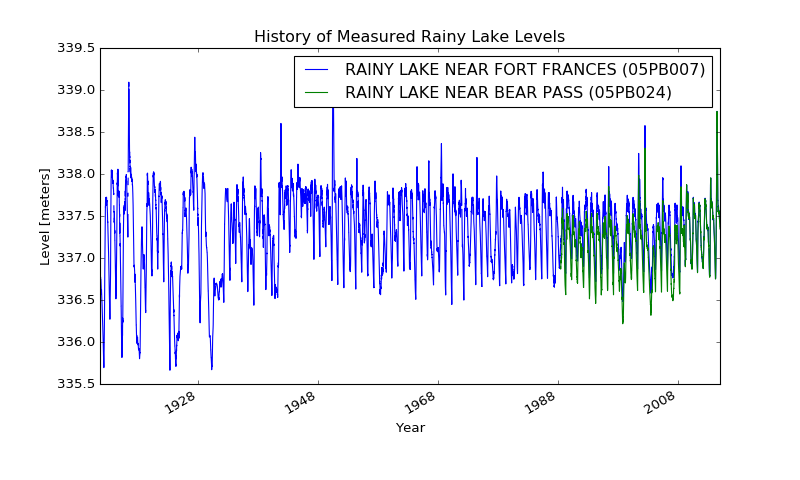

In [4]:
plt.figure(figsize=(10,6))
plt.hold(True)
RL1.plot()
RL2.plot()
plt.hold(False)
plt.legend([RL1.name,RL2.name]);
plt.xlabel('Year')
plt.ylabel('Level [meters]')
plt.title('History of Measured Rainy Lake Levels');

There's an obvious difference between the lake level measured at Fort Frances and at Bear Pass in the period from 1988 to 2009. The level sensor at Bear Pass (05PB024) shows a systematic deviation from the historical data near Fort Frances. Let's look take a more careful look.

<IPython.core.display.Javascript object>


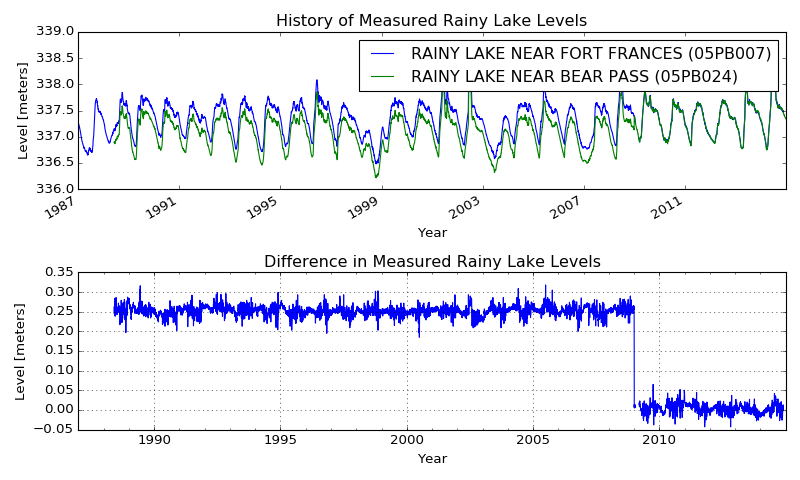

In [5]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.hold(True)
RL1['1987':].plot()
RL2['1987':].plot()
plt.hold(False)
plt.legend([RL1.name,RL2.name]);
plt.xlabel('Year')
plt.ylabel('Level [meters]')
plt.title('History of Measured Rainy Lake Levels');

plt.subplot(2,1,2)
dR = RL1['1987':] - RL2['1987':]
dR.plot()
plt.xlabel('Year')
plt.ylabel('Level [meters]')
plt.title('Difference in Measured Rainy Lake Levels');
plt.grid()

plt.tight_layout()

The abrupt change at the beginning of 2009 appears to be a recalibration of the Bear Pass level sensor. To reconcile the level measurements, we find the mean level difference pre- and post- the change in 2009, then add that difference to the levels reported from Bear Pass prior to 2009.

<IPython.core.display.Javascript object>


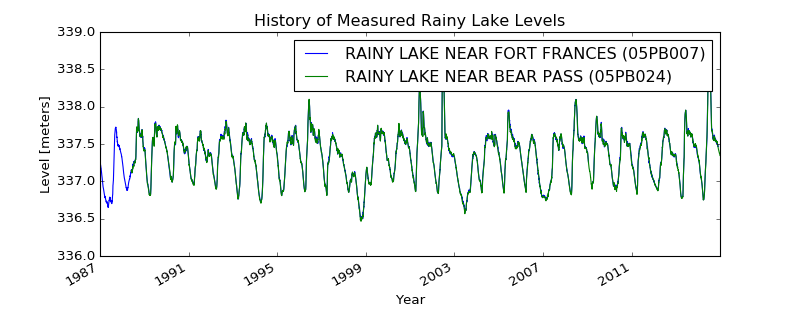

In [6]:
plt.figure(figsize=(10,4))

# Find the point at which there is a big shift
t  = (dR - dR.tshift(1)).argmin()

# Find average differences before and after the shift
preAdj = dR[:t][:-1].mean()
postAdj = dR[t:][1:].mean()

# Adjust the Bear Pass sensor before big shift
RL3 = RL2.copy()
RL3[:t][:-1] += preAdj - postAdj

plt.hold(True)
RL1['1987':].plot()
RL3['1987':].plot()
plt.hold(False)
plt.legend([RL1.name,RL3.name]);
plt.xlabel('Year')
plt.ylabel('Level [meters]')
plt.title('History of Measured Rainy Lake Levels');

We finish by combining the adjusted sensor data into a single time series for the level of Rainy Lake.

<IPython.core.display.Javascript object>


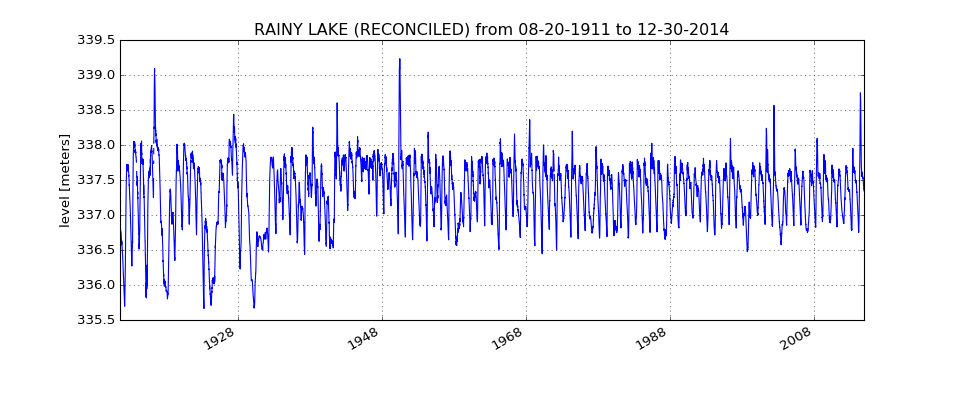

In [7]:

RL = pd.Series(pd.concat([RL1,RL3],axis=1).mean(axis=1))
RL.name = 'RAINY LAKE (RECONCILED)'

plt.figure(figsize=(12,5))
RL.plot()
plt.ylabel('level [meters]')
plt.title(RL.name \
          + ' from ' + RL.index.min().strftime('%m-%d-%Y') \
          + ' to ' + RL.index.max().strftime('%m-%d-%Y'))
plt.grid()

## Writing the Rainy Lake Level Data Series to a File

In [8]:
RL.to_pickle('../data/RL.pkl')

## Statistical Properties of the Level Sensors

The availability of two sensors provides an opportunity to estimate the distribution of the level measurement noise.

0.0115794687305


<IPython.core.display.Javascript object>


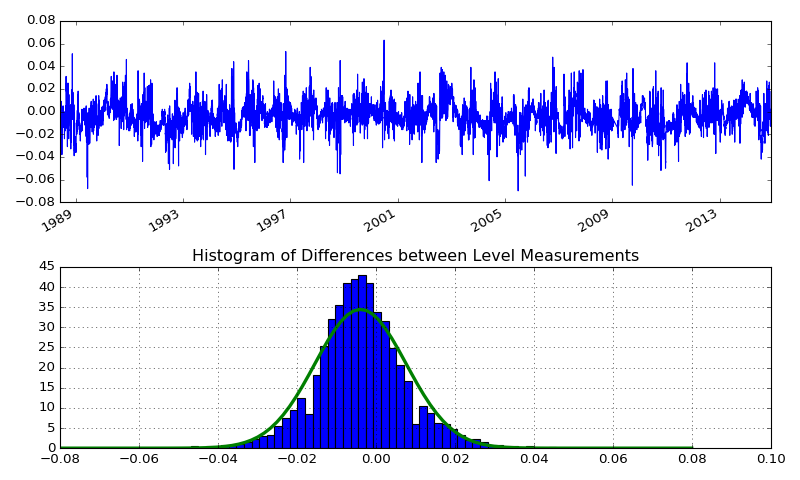

In [9]:
dR = RL3 - RL1
dR = dR[dR.notnull()]

# Statistics
mu = dR.mean();
sigma = dR.std();
print sigma

# Time series plot of the differences between sensors
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
dR.plot()

# Compare empirical and fitted distributions
plt.subplot(2,1,2)
plt.hold(True)
dR.hist(bins = round((0.5*dR.size)**0.5),normed=1)
plt.title('Histogram of Differences between Level Measurements')
ax = plt.axis()
r = np.linspace(ax[0],ax[1],100)
p = [np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*(2*np.pi)**0.5) for x in r]
plt.plot(r,p,linewidth=3)
plt.hold(False)

plt.tight_layout()

### Correlation Analysis

<IPython.core.display.Javascript object>


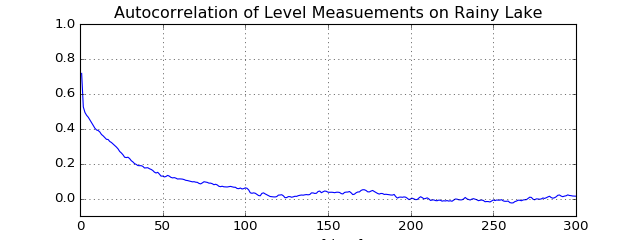

<IPython.core.display.Javascript object>


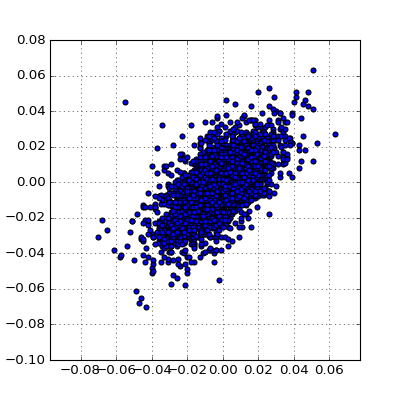

In [10]:
# Autocorrelation

plt.figure(figsize=(8,3))

pd.tools.plotting.autocorrelation_plot(dR)
plt.xlim(0,300)
plt.ylim(-0.1,1.0)
plt.grid()
plt.title('Autocorrelation of Level Measuements on Rainy Lake')
plt.xlabel('Lag [days]')
plt.grid()

# Lag Plots

plt.figure(figsize=(5,5))

pd.tools.plotting.lag_plot(dR)
plt.axis('equal')
plt.grid()